# Stroke Binary Classification

#### Preface:  Stroke dataset was retrieved from Kaggle.  
The aim was to prepare the best classification model, able to determine who is at risk of stroke. 
This was measured by obtaining the highest the recall (highest fraction of relevant instances) for stroke. 

The dataset was extremely imbalanced. This caused major problems with overfitting.
Several differnt solutions were used in attempt to ease this problem. 
Some worked better than others.
 

1. Using the population of >40, where stroke was prevelant.
2. Determining feature importance: 
    Different features and feature combinations were tested for finding ideal fit.
3. Different classification algorithms were tested and the decision tree classifier was found have the same effectivity as Random Forest.
    Other classifiers did not work at all.
5. Grid search and Random oversampling reduced overfitting. 
4. Properly pruning the decision tree gave the best recall. 


### Chain of events:
1. Exploritory Data Analysis
2. Data Cleaning
3. Training and testing
4. Improving the results

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat

from pprint import pprint
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

plt.style.use('seaborn-darkgrid')

In [225]:
df = pd.read_csv('./healthcare-dataset-stroke-data.csv')

In [226]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


# 1. Exploritory Data Analysis

In [157]:
df.shape

(5110, 12)

In [158]:
round(df.describe()).T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36518.0,21162.0,67.0,17741.0,36932.0,54682.0,72940.0
age,5110.0,43.0,23.0,0.0,25.0,45.0,61.0,82.0
hypertension,5110.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
heart_disease,5110.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
avg_glucose_level,5110.0,106.0,45.0,55.0,77.0,92.0,114.0,272.0
bmi,4909.0,29.0,8.0,10.0,24.0,28.0,33.0,98.0
stroke,5110.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [84]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

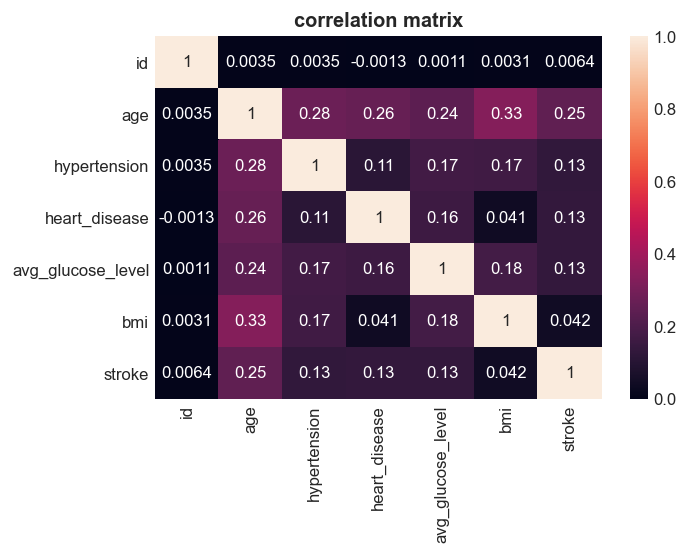

In [85]:
plt.figure(dpi=120)
sns.heatmap(df.corr(), annot=True)
plt.title('correlation matrix', weight='bold')
plt.show()

### Stroke has some correlation with age. 
### Age and BMI have some correlation.

In [86]:
df.stroke.value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

### The target is only 5% of the dataset.  
Dataset is unbalanced.

(-10.0, 100.0)

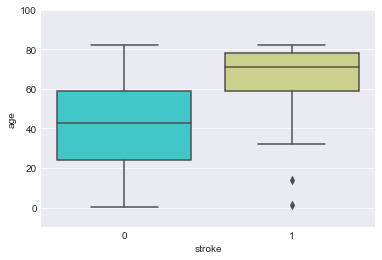

In [87]:
sns.boxplot(x='stroke', y='age', data=df, palette='rainbow')
plt.ylim(-10,100)

### The median age for people with stroke significantly higher that those without stroke.

In [88]:
df.gender.value_counts(normalize=True)

Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64

(-10.0, 100.0)

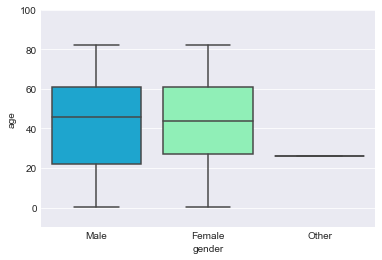

In [89]:
sns.boxplot(x='gender', y='age', data=df, palette='rainbow')
plt.ylim(-10,100)

### There are more males than females in this dataset but it's not overwhelmingly skewed. 
### The age distribution between the genders is similar.

In [90]:
df.hypertension.value_counts(normalize=True)

0    0.902544
1    0.097456
Name: hypertension, dtype: float64

(-10.0, 100.0)

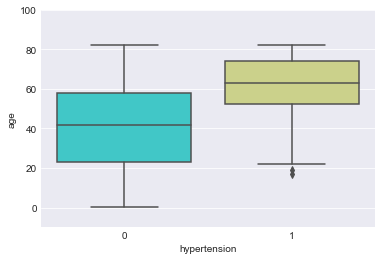

In [91]:
sns.boxplot(x='hypertension', y='age', data=df, palette='rainbow')
plt.ylim(-10,100)

In [92]:
df.heart_disease.value_counts(normalize=True)

0    0.945988
1    0.054012
Name: heart_disease, dtype: float64

(-10.0, 100.0)

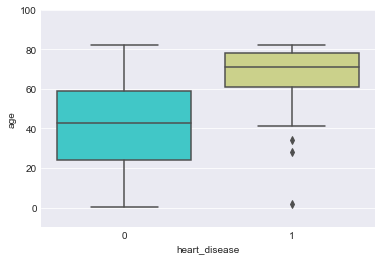

In [93]:
sns.boxplot(x='heart_disease', y='age', data=df, palette='rainbow')
plt.ylim(-10,100)

### The 'heart_disease' feature is similar to the target in that the median age of those with heart disease is higher.
This was investigated later to see if there was a redundency in the features, possibly causing overfitting.
There was no effect on overfitting in presence/absence of this feature, when using decision tree clf. 

In [94]:
df.smoking_status.value_counts(normalize=True)

never smoked       0.370254
Unknown            0.302153
formerly smoked    0.173190
smokes             0.154403
Name: smoking_status, dtype: float64

(-10.0, 100.0)

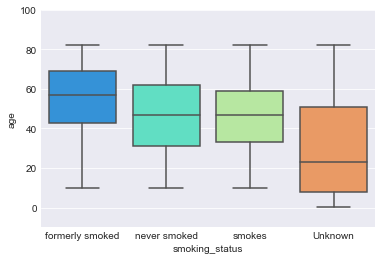

In [95]:
sns.boxplot(x='smoking_status', y='age', data=df, palette='rainbow')
plt.ylim(-10,100)

In [96]:
df.ever_married.value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

(-10.0, 100.0)

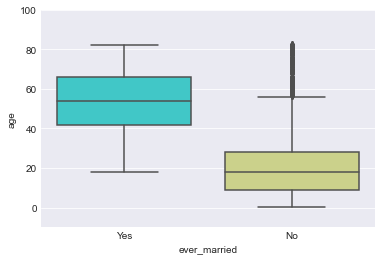

In [97]:
sns.boxplot(x='ever_married', y='age', data=df, palette='rainbow')
plt.ylim(-10,100)

In [98]:
df.Residence_type.value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

(-10.0, 100.0)

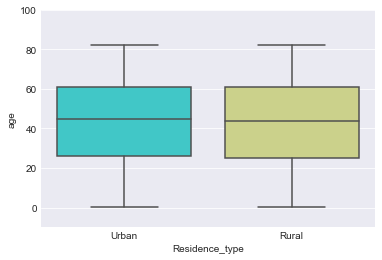

In [99]:
sns.boxplot(x='Residence_type', y='age', data=df, palette='rainbow')
plt.ylim(-10,100)

In [100]:
df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

(-10.0, 100.0)

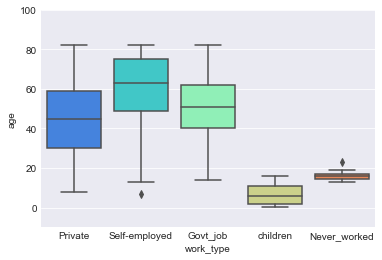

In [101]:
sns.boxplot(x='work_type', y='age', data=df, palette='rainbow')
plt.ylim(-10,100)

### Features: work_type, Residence_type, and ever_married, had no correlative pattern with the target.

### Histrograms for numerical features

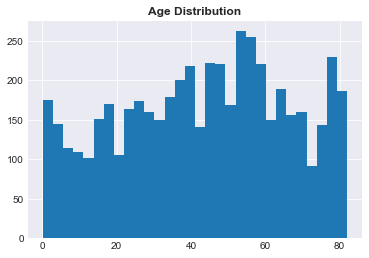

In [102]:
df.hist('age', bins=30)
plt.title("Age Distribution", weight='bold')
plt.show()

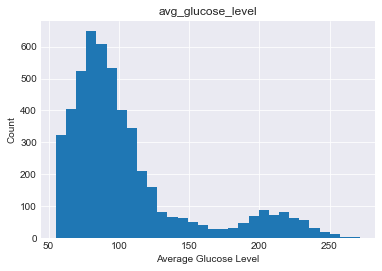

In [76]:
df.hist('avg_glucose_level', bins=30)
plt.xlabel("Average Glucose Level")
plt.ylabel("Count")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef4585f310>]],
      dtype=object)

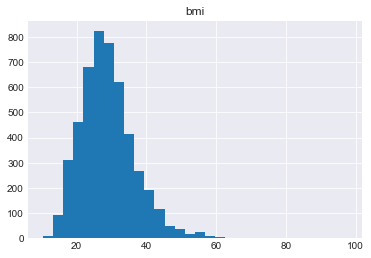

In [77]:
df.hist('bmi', bins=30)

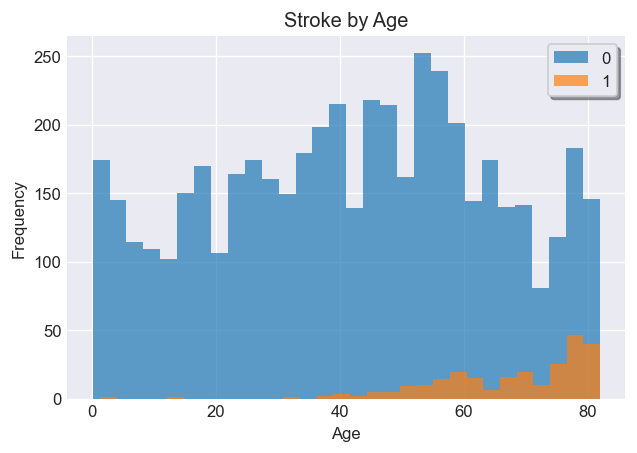

In [22]:
plt.figure(dpi=120)
df.groupby('stroke')['age'].plot(kind='hist', bins=30, legend=True,
                                             alpha=0.7, title='Stroke by Age' )
plt.xlabel('Age')
plt.legend(shadow=True, frameon=True)
plt.show()

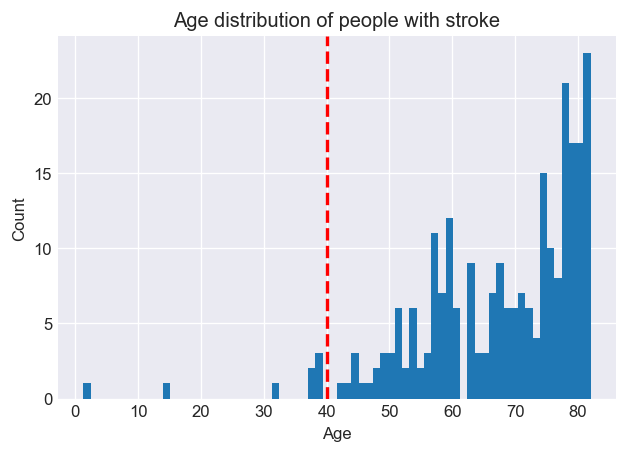

In [23]:
plt.figure(dpi=120)
df_stroke = df[df.stroke==1]
plt.hist(df_stroke.age, bins=70)
plt.title('Age distribution of people with stroke')
plt.axvline(40, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### Stroke rises with age and is barely present under the age of 40.

# 2. Data Cleaning

### 1) Gender Feature

In [24]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [25]:
df.drop(df[df['gender']=='Other'].index,inplace=True)

In [26]:
df[df['gender']=='Other'].index

Int64Index([], dtype='int64')

In [27]:
df['gender'].replace({'Male':1, 'Female':2},  inplace=True)

### 2) Stroke and Age - cleaning outliers

(-10.0, 100.0)

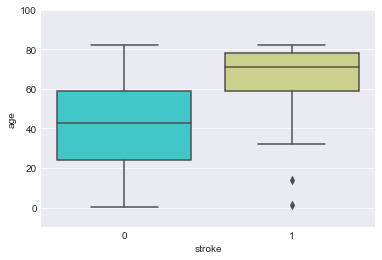

In [28]:
sns.boxplot(x='stroke', y='age', data=df, palette='rainbow')
plt.ylim(-10,100)

In [29]:
df.query('age < 20 and stroke==1')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,2,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,49669,2,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1


In [30]:
df.drop(index=[162, 245], axis=0, inplace=True)

(-10.0, 100.0)

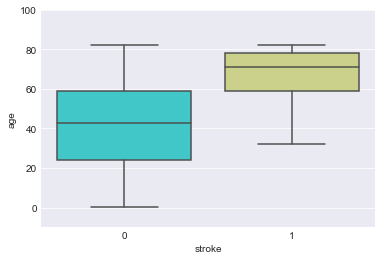

In [31]:
sns.boxplot(x='stroke', y='age', data=df, palette='rainbow')
plt.ylim(-10,100)

### 3) Data imputation of missing values in BMI feature.
The Nan (missing values) were replaced with average BMI from their respective BMI age bins. 

Text(0.5, 1.0, 'Missing Values Heat Map')

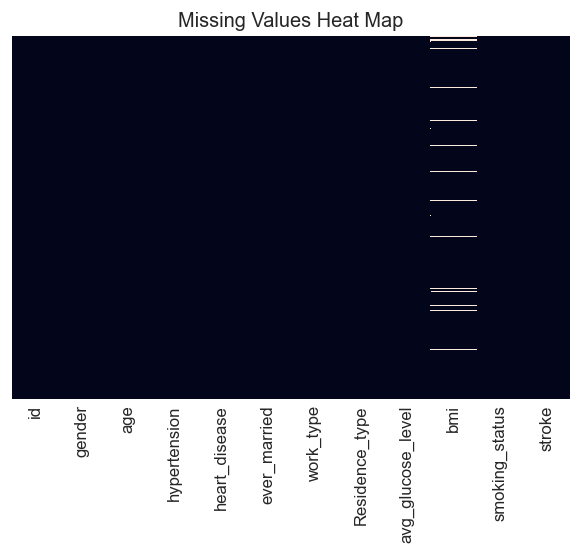

In [32]:
plt.figure(dpi=120)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False)
plt.title("Missing Values Heat Map")

In [33]:
df.age.max()

82.0

In [34]:
# create age bins
bins = [0, 40, 45, 50, 55, 60, 65, 70, 75, 82]
df['age_group']=pd.cut(df.age, bins)
df[['id', 'age', 'age_group']].sample(5)

,id,age,age_group
2374,46068,58.0,"(55, 60]"
2560,54072,11.0,"(0, 40]"
3858,59540,19.0,"(0, 40]"
1650,16488,57.0,"(55, 60]"
1369,39927,40.0,"(0, 40]"


In [35]:
# calculate average BMI for each age bin
age_group_to_meanbmi = df.groupby('age_group').mean()['bmi']
age_group_to_meanbmi

age_group
(0, 40]     26.430660
(40, 45]    31.656198
(45, 50]    31.185552
(50, 55]    32.074402
(55, 60]    31.682353
(60, 65]    31.136420
(65, 70]    30.714167
(70, 75]    29.963063
(75, 82]    28.409513
Name: bmi, dtype: float64

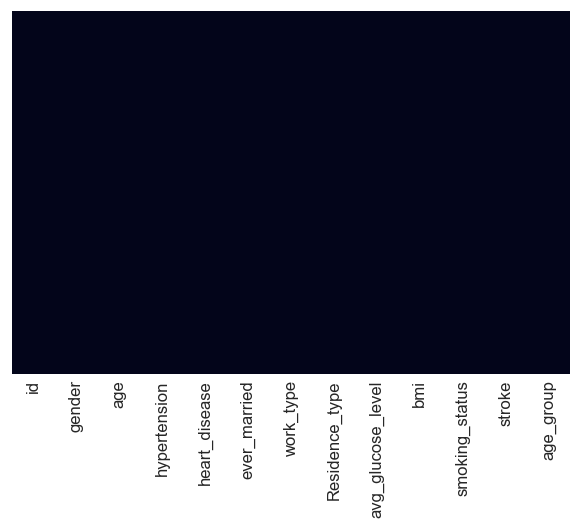

In [36]:
# replace missing values with age group mean BMI values
age_group_to_meanbmi = df.groupby('age_group').mean()['bmi']
for index, column in df.iterrows():
    if np.isnan(column.bmi):
        mean_bmi = column.age_group
        df.loc[index, 'bmi'] = age_group_to_meanbmi[mean_bmi]

plt.figure(dpi=120)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False)

### 4) DF over 40 - making dataset more balanced.

In [37]:
df_over_40 = df[df.age >= 40]
df_over_40.sample()
#df_over_40.shape

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
4838,5131,2,51.0,0,0,Yes,Private,Urban,107.72,60.9,Unknown,0,"(50, 55]"


In [38]:
# now the target is 8% rather than less than 5%
df_over_40.stroke.value_counts(normalize=True)

0    0.918027
1    0.081973
Name: stroke, dtype: float64

### 5) Turning smoking to a numerical feature using dummy

In [107]:
dummy_smoker = pd.get_dummies(df.smoking_status, drop_first=False, prefix='Smoker')
dummy_smoker.head()

,Smoker_Unknown,Smoker_formerly smoked,Smoker_never smoked,Smoker_smokes
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,0,0,1
4,0,0,1,0


In [108]:
dummy_smoker.shape, df.shape

((5110, 4), (5110, 12))

In [109]:
df = pd.concat([df, dummy_smoker], axis=1)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Smoker_Unknown,Smoker_formerly smoked,Smoker_never smoked,Smoker_smokes
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,0,1,0,0
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,0,0,1,0
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,0,0,1,0
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,0,0,0,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,0,0,1,0


# Function for data cleaning

In [217]:
def clean_data(df: pd.DataFrame):
    
    #remove unknown gender (single row)
    df.drop(df[df['gender']=='Other'].index,inplace=True)
    
    #turning the gender feature from a string to numerical
    df['gender'].replace({'Male':1, 'Female':2},  inplace=True)
    
    # removing age outliers for stroke
    df.drop(index=[162, 245], axis=0, inplace=True)
    
    #placing bmi average/age to missing bmi values
    bins = [0, 40, 45, 50, 55, 60, 65, 70, 75, 82]
    pd.cut(df.age, bins)
    df['age_group']=pd.cut(df.age, bins)
    age_group_to_meanbmi = df.groupby('age_group').mean()['bmi']
    for index, column in df.iterrows():
        if np.isnan(column.bmi):
            mean_bmi = column.age_group
            df.loc[index, 'bmi'] = age_group_to_meanbmi[mean_bmi]
            
    #limiting the age to 40 and up.
    df = df[df.age >= 40]
    
    #making smoking statues a numerical feature
    dummy_smoker = pd.get_dummies(df.smoking_status, drop_first=False, prefix='Smoker')
    df = pd.concat([df, dummy_smoker], axis=1)
    

    
    
    return df
    #df.to_csv(/Users/dahliashamir/Documents/Dahlia/John_Bryce/Data_for_project/df_final.csv)

### Data cleaning function

In [218]:
datafile = pd.read_csv('./healthcare-dataset-stroke-data.csv')

In [220]:
df_final = clean_data(datafile)

In [221]:
df_final.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,Smoker_Unknown,Smoker_formerly smoked,Smoker_never smoked,Smoker_smokes
0,9046,1,67.0,0,1,Yes,Private,Urban,228.69,36.60000,formerly smoked,1,"(65, 70]",0,1,0,0
1,51676,2,61.0,0,0,Yes,Self-employed,Rural,202.21,31.13642,never smoked,1,"(60, 65]",0,0,1,0
2,31112,1,80.0,0,1,Yes,Private,Rural,105.92,32.50000,never smoked,1,"(75, 82]",0,0,1,0
3,60182,2,49.0,0,0,Yes,Private,Urban,171.23,34.40000,smokes,1,"(45, 50]",0,0,0,1
4,1665,2,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00000,never smoked,1,"(75, 82]",0,0,1,0


In [114]:
df_final.shape

(2940, 17)

## Additional Data Analysis - using the revised dataframe

In [117]:
df_final.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group', 'Smoker_Unknown',
       'Smoker_formerly smoked', 'Smoker_never smoked', 'Smoker_smokes'],
      dtype='object')

### The feature with the most visible correlation with stroke is age, glucose levels and BMI. 

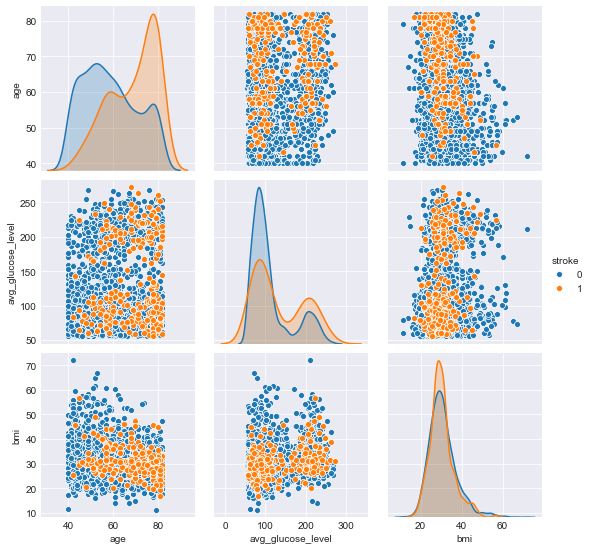

In [118]:
sns.pairplot(df_final[['age', 'avg_glucose_level', 'bmi', 'stroke',]], hue='stroke')
plt.show()

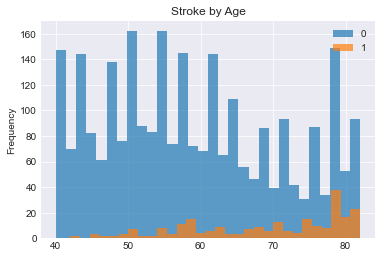

In [119]:
# showing the distribution of stroke in the 40+ population
df_final.groupby('stroke')['age'].plot(kind='hist', bins=30, legend=True,
                                             alpha=0.7, title='Stroke by Age' )

plt.show()

# 3. Training the stroke model

## Features found to be of significance in the Data Analysis

*NOTE: Different feature combinations were used. Often times, when using decision tree clfs, reducing the number of features can improve the overfitting problems. This was not the case for this dataset. The features listed below in 'X_features' was tested to be the most effective combination. 


In [163]:
X_features = ['gender','age', 'hypertension', 'heart_disease','avg_glucose_level', 'bmi', 'Smoker_Unknown', 
              'Smoker_formerly smoked', 'Smoker_never smoked', 'Smoker_smokes']

### Baseline Models - Decision Tree was found to be the model with the highest performance

In [194]:
dtree = DecisionTreeClassifier()

model = dtree


X = df_final[X_features]
y = df_final.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)
model.fit(X_train, y_train)

DecisionTreeClassifier()

### Baseline Train

In [195]:
y_pred = model.predict(X_train)
confusion_matrix(y_train, y_pred)

array([[1819,    0],
       [   0,  150]])

In [196]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1819
           1       1.00      1.00      1.00       150

    accuracy                           1.00      1969
   macro avg       1.00      1.00      1.00      1969
weighted avg       1.00      1.00      1.00      1969



### Baseline test

In [197]:
y_pred_test = model.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

[[816  64]
 [ 80  11]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       880
           1       0.15      0.12      0.13        91

    accuracy                           0.85       971
   macro avg       0.53      0.52      0.53       971
weighted avg       0.84      0.85      0.85       971



### Decision tree train was overfit and test was low. Yet it was the most effective of the classifiers.  

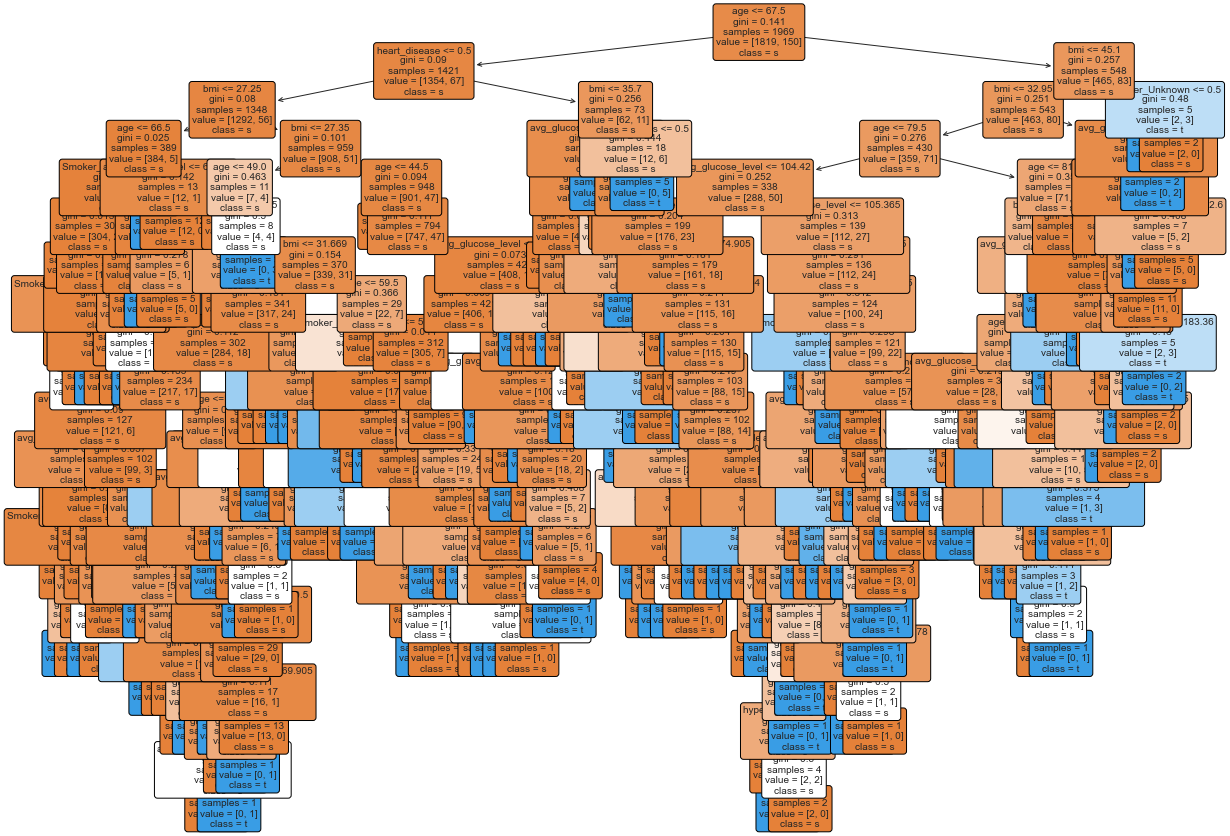

In [168]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,15))
a = plot_tree(dtree,
              feature_names=X_features,
              class_names='stroke',
              filled=True,
              rounded=True,
              fontsize=10)

# 4. Improving the model: Hyperparameter Tuning and Tree Pruning

# Decision Tree Random Grid Search

In [198]:
dtree = DecisionTreeClassifier()

# Look at parameters used by our current dtree
print('Parameters currently in use:\n')
pprint(dtree.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}


In [129]:
param_grid = {'splitter' : ["best", "random"],
              'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 
              'min_samples_split' : [1, 2, 3, 4],
              'min_samples_leaf': [2, 5, 8, 10]}

In [130]:
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='recall', refit=True,verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=2, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 4/5] END max_depth=10,

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.133 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_samples_split=3, spli

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 4/5] END max_depth=10, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=5, min_samples_split=4, splitter=best;, score=0.167 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=5, min_samples_split=4, sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 5/5] END max_depth=10, min_samples_leaf=8, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=8, min_samples_split=2, splitter

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 3/5] END max_depth=10, min_samples_leaf=10, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=10, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=10, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=10, min_samples_split=2, spl

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 5/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.100 total time=   0.0s
[CV 1/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.100 total time=   0.0s
[CV 3/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.067 total time=   0.0s
[CV 1/5] END max_depth=20, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=20, min_samples_leaf=2, min_samples_split=3, sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=20, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=20, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 4/5] END max_depth=20, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=20, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=20, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=20, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 3/5] END max_depth=20, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=20, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=20, min_samples_leaf=5, min_samples_split=3, spli

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 5/5] END max_depth=20, min_samples_leaf=8, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 1/5] END max_depth=20, min_samples_leaf=8, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 2/5] END max_depth=20, min_samples_leaf=8, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 3/5] END max_depth=20, min_samples_leaf=8, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 4/5] END max_depth=20, min_samples_leaf=8, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=20, min_samples_leaf=8, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2, splitter=best;

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 4/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=20, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.167 total time=   0.0s
[CV 4/5] END max_depth=30, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.167 total time=   0.0s
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 1/5] END max_depth=30, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 2/5] END max_depth=30, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.100 total time=   0.0s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=30, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=30, min_samples_leaf=2, min_samples_split=4, sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 5/5] END max_depth=30, min_samples_leaf=5, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 1/5] END max_depth=30, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 2/5] END max_depth=30, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 3/5] END max_depth=30, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 4/5] END max_depth=30, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=30, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=30, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.167 total time=   0.0s
[CV 2/5] END max_depth=30, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=30, min_samples_leaf=5, min_samples_split=2, splitter=best;

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 3/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=30, min_samples_leaf=8, min_samples_split=3, sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=30, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=30, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=30, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=30, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=30, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=30, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=30, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=30, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=30, min_samples_leaf=10, min_samples_spli

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 4/5] END max_depth=40, min_samples_leaf=2, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 5/5] END max_depth=40, min_samples_leaf=2, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 1/5] END max_depth=40, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 2/5] END max_depth=40, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 3/5] END max_depth=40, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 4/5] END max_depth=40, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=40, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=40, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.100 total time=   0.0s
[CV 2/5] END max_depth=40, min_samples_leaf=2, min_samples_split=2, splitter=best;, 

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=40, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=40, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.100 total time=   0.0s
[CV 4/5] END max_depth=40, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=40, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=40, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=40, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 3/5] END max_depth=40, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=40, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=40, min_samples_leaf=5, min_samples_split=2, spli

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 3/5] END max_depth=40, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=40, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=40, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=40, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=40, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=40, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=40, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=40, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=40, min_samples_leaf=8, min_samples_split=3, splitt

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 5/5] END max_depth=40, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=40, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=40, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=40, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=40, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=40, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=40, min_samples_leaf=10, min_samples_split=4, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=40, min_samples_leaf=10, min_samples_split=4, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=40, min_samples_leaf=10, min_samples_sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=50, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.100 total time=   0.0s
[CV 3/5] END max_depth=50, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.200 total time=   0.0s
[CV 4/5] END max_depth=50, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.200 total time=   0.0s
[CV 5/5] END max_depth=50, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.100 total time=   0.0s
[CV 1/5] END max_depth=50, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.100 total time=   0.0s
[CV 2/5] END max_depth=50, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.100 total time=   0.0s
[CV 3/5] END max_depth=50, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=50, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.167 total time=   0.0s
[CV 5/5] END max_depth=50, min_samples_leaf=2, min_samples_split=2, spli

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=50, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=50, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=50, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=50, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=50, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 2/5] END max_depth=50, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=50, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 4/5] END max_depth=50, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=50, min_samples_leaf=5, min_samples_split=3, spli

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=50, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=50, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=50, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=50, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=50, min_samples_leaf=8, min_samples_split=4, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=50, min_samples_leaf=8, min_samples_split=4, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=50, min_samples_leaf=8, min_samples_split=4, splitter=best;, score=0.067 total time=   0.0s
[CV 4/5] END max_depth=50, min_samples_leaf=8, min_samples_split=4, splitter=best;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=50, min_samples_leaf=8, min_samples_split=4, spli

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 3/5] END max_depth=50, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=50, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=50, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=50, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=50, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=50, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=50, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=50, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=50, min_samples_leaf=10, min_samples_sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 1/5] END max_depth=60, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 2/5] END max_depth=60, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 3/5] END max_depth=60, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.200 total time=   0.0s
[CV 4/5] END max_depth=60, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.167 total time=   0.0s
[CV 5/5] END max_depth=60, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 1/5] END max_depth=60, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.100 total time=   0.0s
[CV 2/5] END max_depth=60, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=60, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 4/5] END max_depth=60, min_samples_leaf=2, min_samples_split=3, splitt

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 4/5] END max_depth=60, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=60, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=60, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 2/5] END max_depth=60, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 3/5] END max_depth=60, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=60, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=60, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=60, min_samples_leaf=5, min_samples_split=4, splitter=best;, score=0.100 total time=   0.0s
[CV 2/5] END max_depth=60, min_samples_leaf=5, min_samples_split=4, sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 4/5] END max_depth=60, min_samples_leaf=8, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=60, min_samples_leaf=8, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=60, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=60, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=60, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 4/5] END max_depth=60, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=60, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=60, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=60, min_samples_leaf=8, min_samples_split=2, splitter=r

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 1/5] END max_depth=60, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=60, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=60, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=60, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=60, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=60, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=60, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=60, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=60, min_samples_leaf=10, min_samples_sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 3/5] END max_depth=70, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.167 total time=   0.0s
[CV 4/5] END max_depth=70, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.167 total time=   0.0s
[CV 5/5] END max_depth=70, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 1/5] END max_depth=70, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 2/5] END max_depth=70, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.100 total time=   0.0s
[CV 3/5] END max_depth=70, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=70, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=70, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 1/5] END max_depth=70, min_samples_leaf=2, min_samples_split=4, sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 1/5] END max_depth=70, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 2/5] END max_depth=70, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 3/5] END max_depth=70, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 4/5] END max_depth=70, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=70, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=70, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.200 total time=   0.0s
[CV 2/5] END max_depth=70, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=70, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.100 total time=   0.0s
[CV 4/5] END max_depth=70, min_samples_leaf=5, min_samples_split=2, splitter=bes

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 5/5] END max_depth=70, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=70, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=70, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=70, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=70, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=70, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=70, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=70, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=70, min_samples_leaf=8, min_samples_split=3, sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 3/5] END max_depth=70, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=70, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=70, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=70, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=70, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=70, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=70, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=70, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=70, min_samples_leaf=10, min_samples_sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 3/5] END max_depth=80, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 4/5] END max_depth=80, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=80, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=80, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.133 total time=   0.0s
[CV 2/5] END max_depth=80, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 3/5] END max_depth=80, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.167 total time=   0.0s
[CV 4/5] END max_depth=80, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.167 total time=   0.0s
[CV 5/5] END max_depth=80, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.100 total time=   0.0s
[CV 1/5] END max_depth=80, min_samples_leaf=2, min_samples_split=2, splitter=ran

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=80, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 3/5] END max_depth=80, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.067 total time=   0.0s
[CV 4/5] END max_depth=80, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=80, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=80, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.167 total time=   0.0s
[CV 2/5] END max_depth=80, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=80, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 4/5] END max_depth=80, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=80, min_samples_leaf=5, min_samples_split=3, spli

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 4/5] END max_depth=80, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=80, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=80, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 2/5] END max_depth=80, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=80, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=80, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=80, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=80, min_samples_leaf=8, min_samples_split=4, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=80, min_samples_leaf=8, min_samples_split=4, sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 4/5] END max_depth=80, min_samples_leaf=10, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=80, min_samples_leaf=10, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=80, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=80, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=80, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=80, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=80, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=80, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=80, min_samples_leaf=10, min_samples_split=2, s

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 4/5] END max_depth=90, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=90, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.067 total time=   0.0s
[CV 1/5] END max_depth=90, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 2/5] END max_depth=90, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 3/5] END max_depth=90, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.200 total time=   0.0s
[CV 4/5] END max_depth=90, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.200 total time=   0.0s
[CV 5/5] END max_depth=90, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 1/5] END max_depth=90, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.167 total time=   0.0s
[CV 2/5] END max_depth=90, min_samples_leaf=2, min_samples_split=3, splitt

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 1/5] END max_depth=90, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=90, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=90, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=90, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=90, min_samples_leaf=5, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=90, min_samples_leaf=5, min_samples_split=4, splitter=best;, score=0.200 total time=   0.0s
[CV 2/5] END max_depth=90, min_samples_leaf=5, min_samples_split=4, splitter=best;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=90, min_samples_leaf=5, min_samples_split=4, splitter=best;, score=0.100 total time=   0.0s
[CV 4/5] END max_depth=90, min_samples_leaf=5, min_samples_split=4, sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=90, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=90, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=90, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=90, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=90, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=90, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=90, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=90, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=90, min_samples_leaf=8, min_samples_split=2, spli

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 4/5] END max_depth=90, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=90, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=90, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=90, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=90, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=90, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=90, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=90, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=90, min_samples_leaf=10, min_samples_sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=100, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 3/5] END max_depth=100, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.167 total time=   0.0s
[CV 4/5] END max_depth=100, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.167 total time=   0.0s
[CV 5/5] END max_depth=100, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 1/5] END max_depth=100, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 2/5] END max_depth=100, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 3/5] END max_depth=100, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.100 total time=   0.0s
[CV 4/5] END max_depth=100, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=100, min_samples_leaf=2, min_samples_spli

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 5/5] END max_depth=100, min_samples_leaf=5, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 1/5] END max_depth=100, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 2/5] END max_depth=100, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 3/5] END max_depth=100, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 4/5] END max_depth=100, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=100, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=100, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.167 total time=   0.0s
[CV 2/5] END max_depth=100, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=100, min_samples_leaf=5, min_samples_split=2, split

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 4/5] END max_depth=100, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=100, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=100, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=100, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=100, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=100, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=100, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=100, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=100, min_samples_leaf=8, min_samples_sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 5/5] END max_depth=100, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=100, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=100, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=100, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=100, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=100, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=100, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=100, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=100, min_samples_leaf=10, min_sampl

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 3/5] END max_depth=110, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.167 total time=   0.0s
[CV 4/5] END max_depth=110, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.167 total time=   0.0s
[CV 5/5] END max_depth=110, min_samples_leaf=2, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 1/5] END max_depth=110, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.133 total time=   0.0s
[CV 2/5] END max_depth=110, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 3/5] END max_depth=110, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 4/5] END max_depth=110, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.100 total time=   0.0s
[CV 5/5] END max_depth=110, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.067 total time=   0.0s
[CV 1/5] END max_depth=110, min_samples_leaf=2, min_samples_sp

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=110, min_samples_leaf=5, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 3/5] END max_depth=110, min_samples_leaf=5, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 4/5] END max_depth=110, min_samples_leaf=5, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 5/5] END max_depth=110, min_samples_leaf=5, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 1/5] END max_depth=110, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 2/5] END max_depth=110, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 3/5] END max_depth=110, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 4/5] END max_depth=110, min_samples_leaf=5, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=110, min_samples_leaf=5, min_samples_split=1, splitter=ra

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=110, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=110, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 4/5] END max_depth=110, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=110, min_samples_leaf=8, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=110, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=110, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=110, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.100 total time=   0.0s
[CV 4/5] END max_depth=110, min_samples_leaf=8, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=110, min_samples_leaf=8, min_samples_spli

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=110, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=110, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=110, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=110, min_samples_leaf=10, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=110, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 2/5] END max_depth=110, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=110, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=110, min_samples_leaf=10, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=110, min_samples_leaf=10, min_sam

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 1/5] END max_depth=None, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=None, min_samples_leaf=2, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.100 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.100 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.167 total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_leaf=2, min_samples_spl

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 4/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.033 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.067 total time=   0.0s
[CV 5/5] END max_depth=None, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=None, min_samples_leaf=5, min_samples_split=3, splitter=best;, score=0.100 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=5, min_s

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 2/5] END max_depth=None, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.067 total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 5/5] END max_depth=None, min_samples_leaf=8, min_samples_split=3, splitter=best;, score=0.033 total time=   0.0s
[CV 1/5] END max_depth=None, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.100 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_leaf=8, min_samples_split=3, splitter=random;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=None, min_samples_leaf=8, min_sam

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning

[CV 1/5] END max_depth=None, min_samples_leaf=10, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=10, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=10, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_leaf=10, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 5/5] END max_depth=None, min_samples_leaf=10, min_samples_split=1, splitter=random;, score=nan total time=   0.0s
[CV 1/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.033 total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_leaf=10, min_sa

/Users/dahliashamir/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.06666667 0.04666667 0.08       0.05333333
 0.08       0.04              nan        nan 0.06666667 0.03333333
 0.06666667 0.02666667 0.06666667 0.00666667        nan        nan
 0.02       0.         0.02666667 0.01333333 0.02666667 0.
        nan        nan 0.03333333 0.         0.02666667 0.00666667
 0.03333333 0.                nan        nan 0.14       0.04666667
 0.12       0.05333333 0.12666667 0.06              nan        nan
 0.08       0.02       0.08666667 0.02       0.08666667 0.
        nan        nan 0.03333333 0.02       0.03333333 0.
 0.03333333 0.                nan        nan 0.02666667 0.
 0.02666667 0.         0.02666667 0.                nan        nan
 0.12666667 0.04666667 0.13333333 0.04666667 0.11333333 0.08
        nan        nan 0.08666667 0.03333333 0.08       0.
 0.08666667 0

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'min_samples_leaf': [2, 5, 8, 10],
                         'min_samples_split': [1, 2, 3, 4],
                         'splitter': ['best', 'random']},
             scoring='recall', verbose=3)

In [131]:
grid.best_score_

0.15333333333333335

In [132]:
grid.best_params_

{'max_depth': 100,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'splitter': 'best'}

In [199]:
dtree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=2, min_samples_split=2, splitter='best')

model = dtree


X = df_final[X_features]
y = df_final.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=100, min_samples_leaf=2)

In [200]:
y_pred = model.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[1806   13]
 [  57   93]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1819
           1       0.88      0.62      0.73       150

    accuracy                           0.96      1969
   macro avg       0.92      0.81      0.85      1969
weighted avg       0.96      0.96      0.96      1969



In [201]:
y_pred_test = model.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

[[842  38]
 [ 81  10]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       880
           1       0.21      0.11      0.14        91

    accuracy                           0.88       971
   macro avg       0.56      0.53      0.54       971
weighted avg       0.85      0.88      0.86       971



### The random grid search reduced the overfitting but did not improve the test results.

# RandomOverSampler:

#### Attempts were made to improve the classification by over sampling the target using Randomoversampler.

In [207]:
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train, y_train)
X_ros.shape

(3638, 10)

In [208]:
sum(y_ros==1), sum(y_ros==0)

(1819, 1819)

In [209]:
y_pred = model.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[1806   13]
 [  57   93]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1819
           1       0.88      0.62      0.73       150

    accuracy                           0.96      1969
   macro avg       0.92      0.81      0.85      1969
weighted avg       0.96      0.96      0.96      1969



In [211]:
y_pred_test = model.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

[[842  38]
 [ 81  10]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       880
           1       0.21      0.11      0.14        91

    accuracy                           0.88       971
   macro avg       0.56      0.53      0.54       971
weighted avg       0.85      0.88      0.86       971



#### <br>
Not much improvement was obsereved using Random Over Sampler.<br> 
Other methods, such as 'down sample the majority' and SMOTE were also tested.<br>
Similar results were observed.

# Cost complexity pruning - Hyperparameter tuning 

In [212]:
alphas = [0.001, 0.0013, 0.0017, 0.002, 0.0023, 0.0027, 0.003, 0.0033, 0.0037, 
         0.004, 0.0043, 0.0047, 0.005, 0.0053, 0.0057, 0.006, 0.01]

train_recall_scores = []
test_recall_scores = []

for alpha in alphas:
    dtree = DecisionTreeClassifier(
        ccp_alpha = alpha, class_weight='balanced', criterion='gini', random_state=42, 
        max_depth=100, min_samples_split=2, min_samples_leaf=2, splitter='best')
    
    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_train)
    train_recall_score = recall_score(y_train, y_pred)
    train_recall_scores.append(train_recall_score)
    
    y_pred_test = dtree.predict(X_test)
    test_recall_score = recall_score(y_test, y_pred_test)
    test_recall_scores.append(test_recall_score)

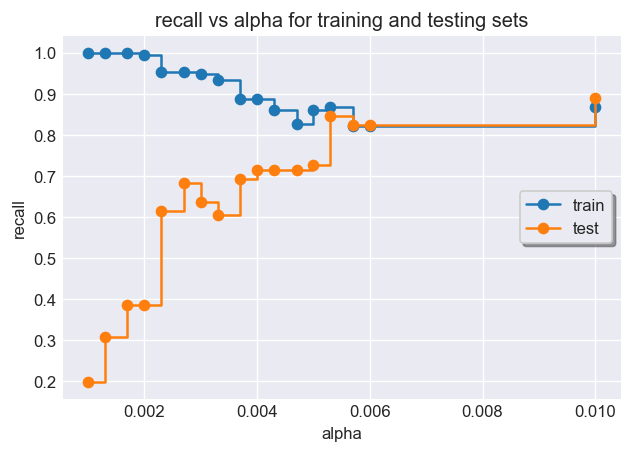

In [213]:
plt.figure(dpi=120)

plt.plot(alphas, train_recall_scores, marker='o', label="train",
        drawstyle="steps-post")
plt.plot(alphas, test_recall_scores, marker='o', label="test",
        drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("recall")
plt.title("recall vs alpha for training and testing sets")
plt.legend(loc='center right', shadow=True, frameon=True)
plt.show()

## *** The graph showes that the ideal ccp_alpha for both train and test was 0.0053 

### Applying this pruning hyperparameter into the decision tree.

In [188]:
# The hyperparameter class_weight was tested with 'weights' and 'balanced'. The 'balanced' was more effective.
# weights = {0:10, 1:90}
# for criterion entropy caused overfitting
dtree = DecisionTreeClassifier(
    ccp_alpha = 0.0053, 
    class_weight='balanced', 
    criterion='gini', 
    random_state=42, 
    max_depth=100, 
    min_samples_split=2, 
    min_samples_leaf=2,
    splitter='best')

model = dtree

In [189]:
X = df_final[X_features]
y = df_final.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0053, class_weight='balanced', max_depth=100,
                       min_samples_leaf=2, random_state=42)

# Training the Decision Tree

In [190]:
y_pred = model.predict(X_train)
confusion_matrix(y_train, y_pred)

array([[1096,  723],
       [  20,  130]])

In [191]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.60      0.75      1819
           1       0.15      0.87      0.26       150

    accuracy                           0.62      1969
   macro avg       0.57      0.73      0.50      1969
weighted avg       0.92      0.62      0.71      1969



# Test Decision Tree Model

In [192]:
y_pred_test = model.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

[[512 368]
 [ 14  77]]
              precision    recall  f1-score   support

           0       0.97      0.58      0.73       880
           1       0.17      0.85      0.29        91

    accuracy                           0.61       971
   macro avg       0.57      0.71      0.51       971
weighted avg       0.90      0.61      0.69       971



In [193]:
feature_names = list(X_train.columns)

importances = list(model.feature_importances_)

data_dict = {'feature_names': feature_names,
            'importances': importances}

data_dict


df_features = pd.DataFrame(data_dict)
df_features.sort_values(by='importances', ascending=False, inplace=True)

In [176]:
df_features

,feature_names,importances
1,age,0.573197
5,bmi,0.207989
4,avg_glucose_level,0.120664
8,Smoker_never smoked,0.057053
3,heart_disease,0.041097
0,gender,0.000000
2,hypertension,0.000000
6,Smoker_Unknown,0.000000
7,Smoker_formerly smoked,0.000000
9,Smoker_smokes,0.000000


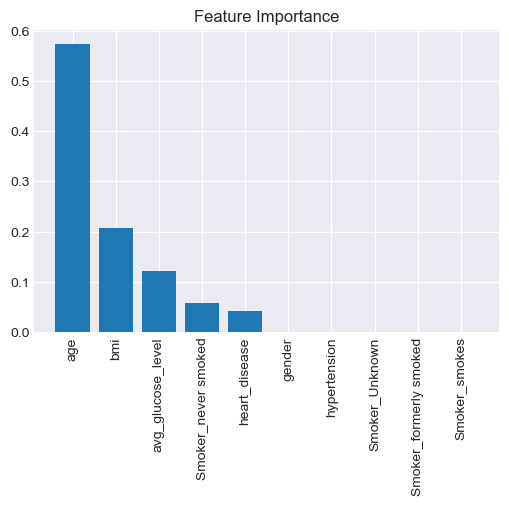

In [178]:
plt.figure(dpi=100)
plt.bar(x=df_features.feature_names, height=df_features.importances)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()

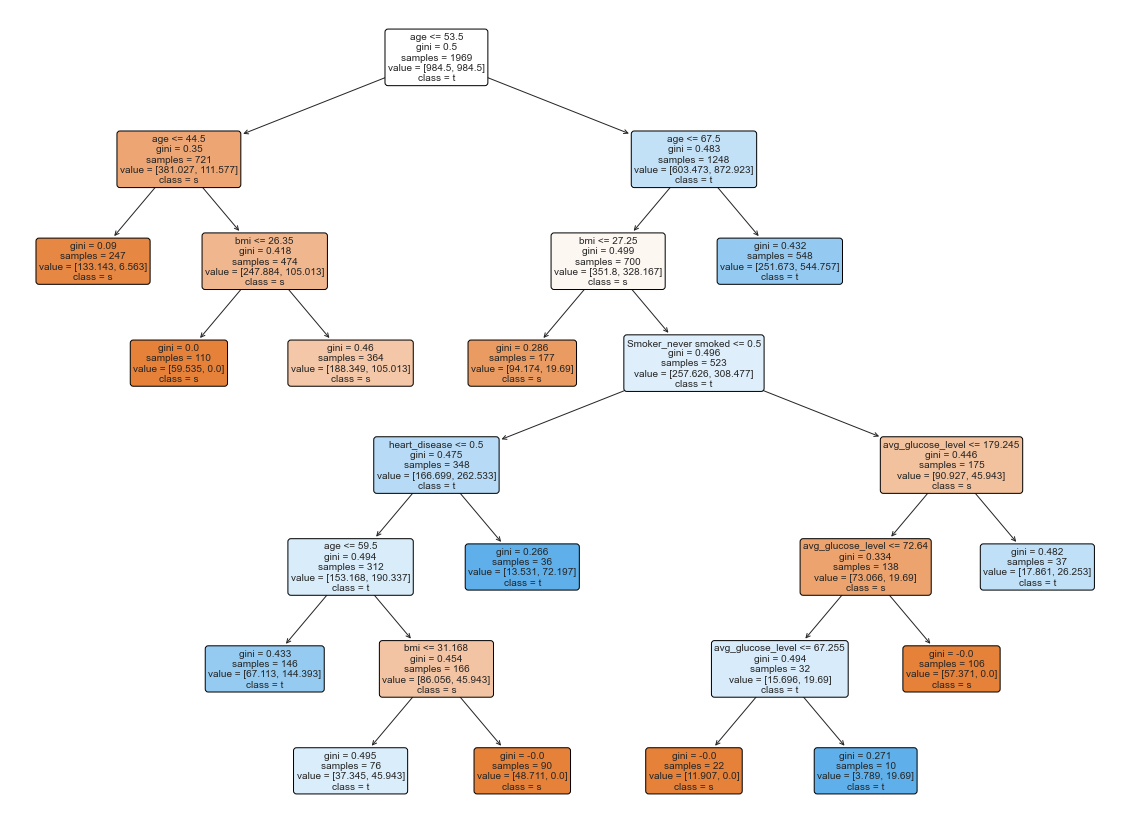

In [179]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,15))
a = plot_tree(dtree,
              feature_names=X_features,
              class_names='stroke',
              filled=True,
              rounded=True,
              fontsize=10)

# Conclusions:
### Decision tree was the model with the best performance. 
The most important features in this model were age, BMI and average glucose level. <br>
The train set was initially overfit.<br>
Hyperparameters were tuned to overcome this problem.<br>
Grid search found that 'entropy' was better than 'gini' but this was also causing overfitting in the train.<br> 
The best tuning was found using:
1. class_weight as 'balanced'
2. finding the best ccp_alpha by optimizing for recall

The recall was thoroughly improved. <br>This was the most important aspect of the classification, since the idea was to identify those at risk of stroke.<br>
The precision and the f1 score were low.


In [229]:
class Model:
    def __init__(self, datafile = pd.read_csv('./healthcare-dataset-stroke-data.csv')):
        self.df_final = clean_data(datafile)
        self.dtree = DecisionTreeClassifier(
        ccp_alpha = 0.0053, 
        class_weight='balanced', 
        criterion='gini', 
        random_state=42, 
        max_depth=100, 
        min_samples_split=2, 
        min_samples_leaf=2,
        splitter='best')
        self.rforest = RandomForestClassifier(n_estimators=100,min_samples_leaf=2)
    
    def split(self, test_size):
        X = np.array(self.df_final[['gender','age', 'hypertension', 'heart_disease','avg_glucose_level', 'bmi', 'Smoker_Unknown', 
              'Smoker_formerly smoked', 'Smoker_never smoked', 'Smoker_smokes']])
        y = np.array(self.df_final['stroke'])
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = test_size, 
                                                                                random_state=101)
    
    def fit(self):
        self.model = self.dtree.fit(self.X_train, self.y_train)
    
    def predict(self):
        self.y_pred_train = self.dtree.predict(self.X_train) 
        self.y_pred_test = self.dtree.predict(self.X_test) 
        result = self.dtree.fit(self.X_test, self.y_test)
        return result
        

if __name__ == '__main__':
    model_instance = Model()
    model_instance.split(0.4)
    model_instance.fit()
    model_instance.predict()
    print("Confusion matrix and classification report of the TRAIN set:" ,'\n')
    print(confusion_matrix(model_instance.y_train, model_instance.y_pred_train))
    print(classification_report(model_instance.y_train, model_instance.y_pred_train))
    print("Confusion matrix and classification report of the TEST set: ",'\n')
    print(confusion_matrix(model_instance.y_test, model_instance.y_pred_test))
    print(classification_report(model_instance.y_test, model_instance.y_pred_test))

Confusion matrix and classification report of the TRAIN set: 

[[947 686]
 [ 16 115]]
              precision    recall  f1-score   support

           0       0.98      0.58      0.73      1633
           1       0.14      0.88      0.25       131

    accuracy                           0.60      1764
   macro avg       0.56      0.73      0.49      1764
weighted avg       0.92      0.60      0.69      1764

Confusion matrix and classification report of the TEST set:  

[[605 461]
 [ 16  94]]
              precision    recall  f1-score   support

           0       0.97      0.57      0.72      1066
           1       0.17      0.85      0.28       110

    accuracy                           0.59      1176
   macro avg       0.57      0.71      0.50      1176
weighted avg       0.90      0.59      0.68      1176

